In [ ]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import pandas_profiling
import numpy as np
import re
import requests
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
import types

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read the task1_train data
train_df = pd.read_csv("drive/My Drive/task1_train.csv", low_memory=False, header=0)
train_df

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,status_group
0,17667,250.0,1409,29.936235,-4.422470e+00,0,370,functional needs repair
1,73543,0.0,436,34.607098,-1.055015e+01,0,160,functional needs repair
2,29657,0.0,0,0.000000,-2.000000e-08,0,0,functional needs repair
3,12515,0.0,991,30.394823,-5.106162e+00,0,550,functional needs repair
4,18756,0.0,0,33.002953,-9.064479e+00,0,0,others
...,...,...,...,...,...,...,...,...
6902,38745,20.0,506,39.298712,-1.069067e+01,0,1,functional needs repair
6903,27918,500.0,1227,36.908360,-3.356076e+00,0,120,functional needs repair
6904,22550,0.0,0,30.686126,-1.252510e+00,0,0,functional needs repair
6905,19770,0.0,0,31.318268,-2.645071e+00,0,0,functional needs repair


In [ ]:
#Read the task1_test data
test_df = pd.read_csv("drive/My Drive/task1_test.csv", low_memory=False, header=1)
test_df

,45786,0.0,0,34.02336747,-3.53830192,0.1,0.2,functional needs repair
0,39181,0.0,1141,36.901475,-3.391345,0,360,others
1,60073,0.0,1236,34.842991,-6.074815,0,300,others
2,10708,300.0,1327,37.200640,-3.228018,0,35,others
3,60497,0.0,0,31.517362,-1.601114,0,0,functional needs repair
4,60650,0.0,0,36.815359,-6.306212,0,0,others
...,...,...,...,...,...,...,...,...
1721,40993,500.0,1428,34.597312,-8.947388,0,250,functional needs repair
1722,52924,0.0,0,36.552113,-6.687545,0,0,others
1723,55202,0.0,0,33.517984,-3.430887,0,0,others
1724,2071,0.0,1417,36.748423,-3.079985,0,150,functional needs repair


In [ ]:
#Read the task1_test data
nolabels_test_df = pd.read_csv("drive/My Drive/task1_test_nolabels.csv", low_memory=False, header=1)
nolabels_test_df

,45786,0.0,0,34.02336747,-3.53830192,0.1,0.2
0,39181,0.0,1141,36.901475,-3.391345,0,360
1,60073,0.0,1236,34.842991,-6.074815,0,300
2,10708,300.0,1327,37.200640,-3.228018,0,35
3,60497,0.0,0,31.517362,-1.601114,0,0
4,60650,0.0,0,36.815359,-6.306212,0,0
...,...,...,...,...,...,...,...
1721,40993,500.0,1428,34.597312,-8.947388,0,250
1722,52924,0.0,0,36.552113,-6.687545,0,0
1723,55202,0.0,0,33.517984,-3.430887,0,0
1724,2071,0.0,1417,36.748423,-3.079985,0,150


In [ ]:
nolabels_test_df.shape

(1726, 7)

In [ ]:
train_df.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'population', 'status_group'],
      dtype='object')

In [ ]:
test_df.shape

(1726, 8)

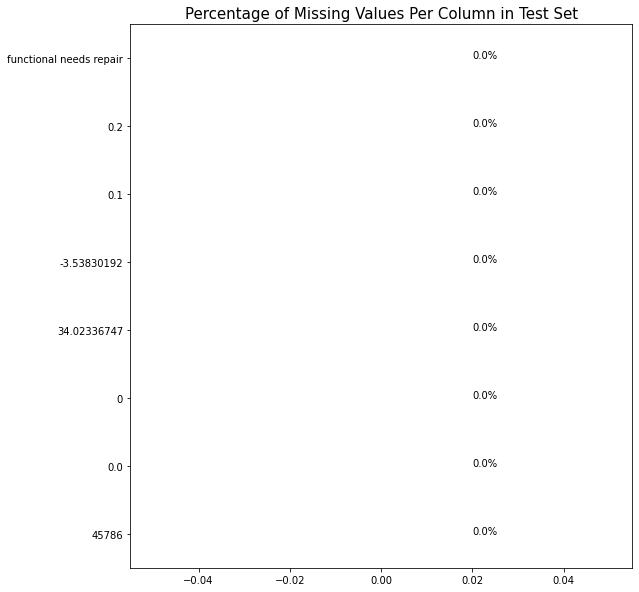

In [ ]:
# Check if there missing values in test set
ax = test_df.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test_df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [ ]:
train_df.shape

(6906, 8)

In [ ]:
train_df.dtypes

id                int64
amount_tsh      float64
gps_height        int64
longitude       float64
latitude        float64
num_private       int64
population        int64
status_group     object
dtype: object

In [ ]:
#Check for missing values
train_df.isna().sum()

id              0
amount_tsh      0
gps_height      0
longitude       0
latitude        0
num_private     0
population      0
status_group    0
dtype: int64

In [ ]:
#Check for duplicates
train_df.duplicated().any()

False

Now that we do not have duplicate thats good 

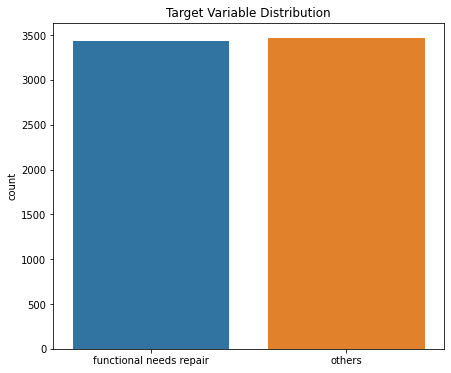

In [ ]:
#Hwre we will divide data for training
ntrain = train_df.shape[0] #will be used to seperate the train and test data from the combined dataset

combined_df = pd.concat((train_df, test_df)).reset_index(drop=True)
print(f'shape of the combined data is {combined_df.shape}')



shape of the combined data is (8632, 14)


In [ ]:
print(combined_df.iloc[:,-1].unique())

[      nan 3.600e+02 3.000e+02 3.500e+01 0.000e+00 4.670e+02 1.000e+00
 1.950e+02 6.000e+02 6.800e+02 1.300e+02 4.200e+02 2.000e+03 5.000e+01
 2.300e+02 4.000e+02 5.160e+02 1.690e+02 2.000e+02 4.000e+01 2.680e+02
 3.000e+01 8.000e+02 1.700e+03 3.500e+02 1.000e+02 2.000e+01 1.200e+02
 6.300e+02 1.400e+02 5.000e+02 1.700e+02 2.500e+02 3.200e+02 2.500e+01
 9.600e+01 5.200e+01 4.500e+01 2.400e+01 2.110e+02 2.100e+02 2.500e+03
 2.620e+02 6.980e+02 1.000e+01 8.200e+02 1.170e+02 7.500e+01 4.500e+02
 5.500e+01 2.010e+02 1.500e+02 9.800e+01 6.000e+01 1.890e+02 6.600e+02
 5.430e+02 5.700e+02 5.200e+02 3.170e+02 4.750e+02 7.500e+02 5.400e+02
 8.000e+01 2.060e+02 7.460e+02 2.560e+02 4.300e+02 1.000e+03 5.300e+02
 6.500e+02 2.160e+02 2.090e+02 2.450e+02 5.600e+01 4.600e+02 1.450e+02
 7.000e+02 1.500e+03 4.800e+01 1.800e+01 2.190e+02 5.290e+02 1.750e+02
 3.680e+02 9.900e+01 1.300e+03 7.000e+01 1.230e+03 1.280e+02 2.400e+02
 3.700e+02 1.850e+02 2.510e+02 1.230e+02 5.600e+02 4.100e+02 1.500e+01
 1.520

In [ ]:
#Split the combined data
train = combined_df[:ntrain]
test = combined_df[ntrain:]

In [ ]:
train.shape, test.shape

((6907, 8), (1727, 8))

In [ ]:
#Split the input(X) and output(Y) of the data
main_cols = combined_df.columns.difference(['status_group', 'id'])
X = combined_df[main_cols].astype(float)
Y = combined_df["status_group"]

In [ ]:
X

,amount_tsh,gps_height,latitude,longitude,num_private,population
0,250.0,1409.0,-4.422470e+00,29.936235,0.0,370.0
1,0.0,436.0,-1.055015e+01,34.607098,0.0,160.0
2,0.0,0.0,-2.000000e-08,0.000000,0.0,0.0
3,0.0,991.0,-5.106162e+00,30.394823,0.0,550.0
4,0.0,0.0,-9.064479e+00,33.002953,0.0,0.0
...,...,...,...,...,...,...
8629,500.0,1428.0,-8.947388e+00,34.597312,0.0,250.0
8630,0.0,0.0,-6.687545e+00,36.552113,0.0,0.0
8631,0.0,0.0,-3.430887e+00,33.517984,0.0,0.0
8632,0.0,1417.0,-3.079985e+00,36.748423,0.0,150.0


In [ ]:
Y

0       functional needs repair
1       functional needs repair
2       functional needs repair
3       functional needs repair
4                        others
                 ...           
8629    functional needs repair
8630                     others
8631                     others
8632    functional needs repair
8633                     others
Name: status_group, Length: 8634, dtype: object

In [ ]:
#Import libraries for our model
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
#Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [ ]:
encoded_Y

array([0, 0, 0, ..., 1, 0, 1])

In [ ]:
#baseline model
def create_baseline():
  #Create a model
  model = Sequential()
  model.add(Dense(60, input_dim=60, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  #Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
X_train = X[:ntrain]
Y_train = encoded_Y[:ntrain]

In [ ]:
X_train.shape, Y_train.shape

((6907, 6), (6907,))

In [ ]:
Y_train.mean()

0.5018097582163022

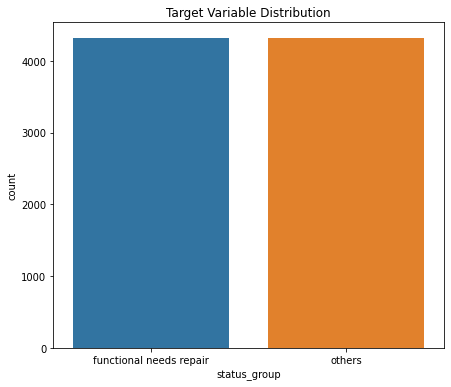

In [ ]:
#Check distribution of targets
plt.figure(figsize=(7, 6))
sns.countplot(combined_df.status_group)
plt.title('Target Variable Distribution');

In [ ]:
#evaluate the model
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train,  Y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Baseline: nan% (nan%)


In [ ]:
#evaluate baseline model with standardized data
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
print(results.mean())
print("Standardize: %.2f%% (%.2f%%)" %(results.mean()*100, results.std()*100))

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
nan
Standardize: nan% (nan%)
